# Sentiment Analysis from Women's Clothing Review using Multinomial Naive Bayes

<h2>Introduction</h2>

<div style="text-align:justify">Product user reviews hold an important role in E-commerce industry. Quality of the product can be measured by review given by customer. New costumer can decided whether she/he buy the product or not by recommendation or review from previous customers. We can classify review from costumer into 2 class value, "recommended" means that the products are good and "not recommended" means that the products are bad.</div>
<div style="text-align:justify">Text classification aims to assign documents into one or many categories and one kind of the most useful text classification is Sentiment analysis. Sentiment analysis is objective to determine the writer’s point of view about a particular topic, product, or service.</div>
<div style="text-align:justify">In this notebook we will determine whether the product recommended or not  using  sentiment analysis from customers review with Multinomial Naive Bayes Classification. The dataset used is a dataset from Woman Clhoting Review that can be accessed in (https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews).</div>

<h2>Data Wrangling</h2>

<h4>Import some important packages</h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<h4>Read the data</h4>

In [2]:
data = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")


In [3]:
data.head(2)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


<div style="text-align:justify">Original data have several variable like Clothing ID, Age of reviewer, Title, Review Text, Rating, Recommended IND, Positive Feedback Count, Division Name, Department Name, and Class Name. But in this case, we only use Review Text and Recommended IND as a predictor and target class variable. So let's do filtering the variable: </div>

In [4]:
data = data[['Review Text','Recommended IND']]

<b>Variable Explanation :</b><br>
`Review Text` : Contains review from customers and will be used as predictor variable.<br>
`Recommended IND` : Contains recommendation from customers, whether the product recommended or not, will be used as target variable.

<h4>Get Dimension of the Data</h4>

In [5]:
data.shape

(23486, 2)

<h4>Renaming Columns</h4>

In [6]:
data.rename(columns={'Review Text':'review_text','Recommended IND':'recommended'},inplace=True)

In [7]:
data.head(2)

,review_text,recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1


<h4>Checking and Handling Missing Values</h4>

In [8]:
data.isna().sum()

review_text    845
recommended      0
dtype: int64

<div style="text-align:justify">From 2 variable above, review_text have so many missing values. Removing those missing values can lead to lack of information from the data, so instead of remove the data, let's fill missing values with blank space.</div>

In [9]:
data['review_text'] = data['review_text'].fillna(' ')

In [10]:
data.isna().sum()

review_text    0
recommended    0
dtype: int64

In [11]:
data.dtypes

review_text    object
recommended     int64
dtype: object

<h2>Exploratory Data Analysis (EDA)</h2>

<h4>Renaming Target Variable Values</h4>
Instead of using 0 and 1 as values of target variable, we can use more appropiate values like "Not Recommended" and "Recommended".

In [12]:
data.loc[data["recommended"] == 0, "recommended"] = "Not Recommended" # 0 -> Not Recommended
data.loc[data["recommended"] == 1, "recommended"] = "Recommended" # 1 -> Recommended

In [13]:
data.dtypes

review_text    object
recommended    object
dtype: object

<h4>Check Proportion Target Class Variable</h4>

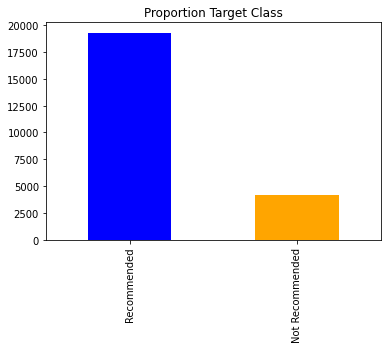

In [14]:
count_class=pd.value_counts(data["recommended"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [15]:
print('Recommended', round(data['recommended'].value_counts()['Recommended']/len(data) * 100), '%')
print('Not Recommended', round(data['recommended'].value_counts()['Not Recommended']/len(data) * 100), '%')

Recommended 82.0 %
Not Recommended 18.0 %


<div style="text-align:justify">Target class variable have imbalance proportion, where "Recommended" values more dominating with a proportion value of 82% and the rest "Not Recommendation" only 18%</div>

<h4>Check Most Common Words in Each Target Variable Values</h4>

In [16]:

count1 = Counter(" ".join(data[data['recommended']== 'Recommended']['review_text']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)


In [17]:
df1 = df1.rename(columns={0: "common_words", 1 : "count"})
df1.head(10)

,common_words,count
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [18]:
count2 = Counter(" ".join(data[data['recommended']== 'Not Recommended']['review_text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)


In [19]:
df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,15744
1,i,8841
2,and,8116
3,it,7514
4,a,6804
5,is,4799
6,to,4547
7,was,4137
8,this,4050
9,in,3705


In [20]:
data.iloc[1,0]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

<div style="text-align:justify">From the result above, most common words in target class variable contains so many stop words like "the, was, in, it, is" and etc. Which mean that the review_text still have untidy data. There are so many punctuation, constraction, and elongation words. Before we go to the modelling steps we need to removing those all, and make the text become tidy data text.</div>

<h2>Text Mining</h2>

<div style="text-align:justify">In this text mining process we will exploring and analyzing unstructured text data</div>  

In [21]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [22]:
main_text = data['review_text']
target = data['recommended']

print(len(main_text))
print(len(target))

23486
23486


<h4>Expanding Contraction</h4>

In [23]:
contractions_dict = {     
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

<div style="text-align:justify">Contractions is kind of word like I'm, ain't, who's, etc. By expanding the contractions "I'm" will become "I am", "ain't" will become "am not", and so on.</div>

In [24]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def cons(text):
    text=expand_contractions(text,contractions_dict)
    return text

main_text = main_text.apply(cons)

<h4>To lowercase</h4><br>
Change all uppercase character to be lowercase character. For example "Pretty" to be "pretty" or "BEAUTY" to be "beauty"

In [25]:
#Tolowercase
def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])

main_text = main_text.apply(to_lower)

<h4>Remove Special Character and Punctuation</h4><br>
Removing all special character like .?/@# etc

In [26]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

main_text = main_text.apply(remove_special_characters)
main_text = main_text.apply(strip_punctuation)

<h4>Replace Elongated Words</h4><br>
Replace all elongated words with appropriate words. For example "soooooo" to be "so" or "looooong" to be "long"


In [27]:
from nltk.corpus import wordnet

def replaceElongated(word):
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word
main_text = main_text.apply(replaceElongated)

<h4>Tokenization</h4><br>
Tokenization is splitting sentences into smaller unit, such as terms or word. 

In [28]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))


<h4>Removing Stopwords</h4><br>
Remove stopwords like "is, the, with, etc" since they don't have usefull information

In [29]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

<h4>Stemming</h4><br>
Stemming is the process of reducing a word to its word stem. For example "Consulting" to be "consult"

In [30]:
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = snowball_stemmer.stem(word)
        text_list_new.append(word)
    return text_list_new
main_text = main_text.apply(stem_update)


<h4>Drop Numbers</h4><br>
Remove numbers from text, since numbers doesn't give much importance to get the main words.

In [31]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
main_text = main_text.apply(drop_numbers)

In [32]:
df = pd.concat([main_text,target],axis=1)

In [33]:
df.head(2)

,review_text,recommended
0,absolut wonder silki sexi comfort,Recommended
1,love dres preti hapen find store glad bc never...,Recommended


<h4>Most Common Words in Recommended Review</h4>

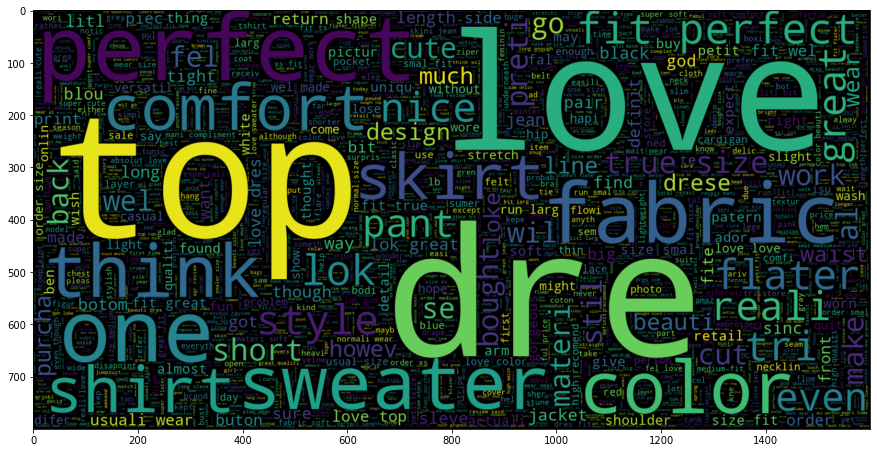

In [34]:
plt.figure(figsize = (15,15)) # Text that is recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

<h4>Most Common Words in Not Recommended Review</h4>

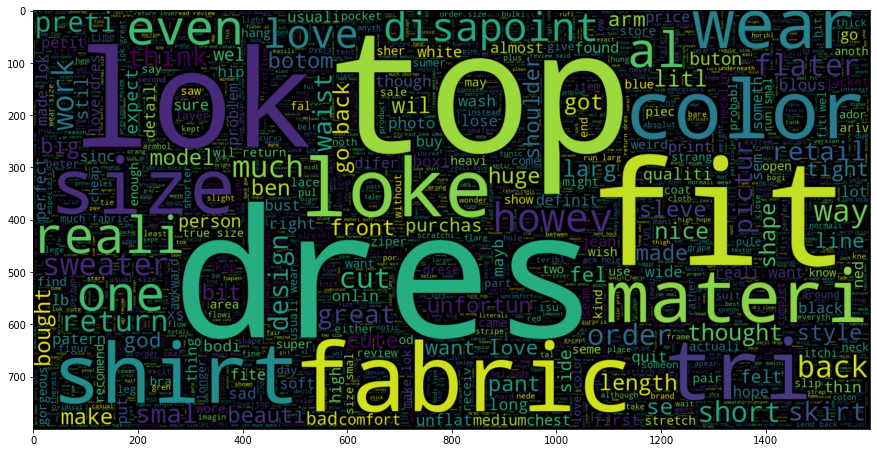

In [35]:
plt.figure(figsize = (15,15)) # Text that is not recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Not Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

<h2>Modelling using Multinomial Naive Bayes</h2>

<h4>Split the data and count the vectorize in each words</h4>

<div style="text-align:justify">The next step is to create a numerical feature vector for each document and split them into train data and test data.</div>

In [36]:
cv=CountVectorizer()


train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)

X_train = cv.fit_transform(train_data['review_text'])
y_train = train_data['recommended']
X_test = cv.transform(test_data['review_text'])
y_test = test_data['recommended']

In [37]:
print(X_train.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<h4>Multinomial Naive Bayes Modelling</h4>
<div style="text-align:justify">Naive Bayes is one of algorithms method based on applying Bayes theorem.Bayes theorem calculates probability P(c|x) where c is the class of the possible outcomes and x is the given instance which has to be classified. Herre below the formula of naive bayes:</div>

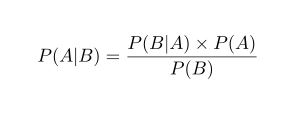

Where:<br>
`P(A|B)` : measure of how often A and B are observed to occure together (posterior probability) <br>
`P(B|A)` : measures of how often B occur in A (likelihood)<br>
`P(A)` : measure of how often A is observed to occur in general (prior probability) <br>
`P(B)` : measure of how often B is observed to occur in general (marginal likelihood)<br>

In [38]:
nb = MultinomialNB()
nb.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
nb_predict=nb.predict(X_test)

<h4>Matrix Evaluation</h4><br>
After we get the result from our modelling, the next step is evaluate our model using matrix evaluation as follows:

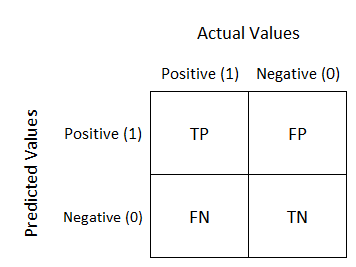

Where :<br>
`TP (True Positive)` : Predicted positive and the actual's positive <br>
`TN (True Negative)` : Predicted negative and the actual's negative <br>
`FP (False Positive)` : Predicted positive but the actual's negative <br>
`FN (False Negative)` : Predicted negative but the actual's positive <br>

From confusion Matrix above we can calculate best evaluation metric for our model: <br>
<b>Accuracy :</b>Out of all the classes were predicted correctly.<br>
<b>Recall :</b> Out of all the actual positive classes were predicted correctly.<br>
<b>Precision :</b> Out of all the predicted positive classes were actually positive  

In [40]:
nb_report = accuracy_score(y_test,nb_predict)
print('Accuracy:',nb_report)

Accuracy: 0.8914431673052363


In [41]:
nb_report1 = recall_score(y_test,nb_predict,pos_label='Recommended',average='binary')
print('Recall:',nb_report1)

Recall: 0.9480620155038759


In [42]:
nb_report2 = precision_score(y_test,nb_predict,pos_label='Recommended',average='binary')
print('Precision:',nb_report2)

Precision: 0.9223227752639518


<div style="text-align:justify">"Recommended" value will be the main parameter in calculating Recall and Precision, sice we will analyze whether the product worth for buy or not.</div>
<div style="text-align:justify">From the result above, we get the value of Accuracy around in 0.89 which means that we have 89% level of confidence that the model was accurate.</div>
<div style="text-align:justify">And we have the <b>Recall</b> value around in 0.95 which means that we have 95% "Recommended" review which predicted correctly.</div>
<div style="text-align:justify">And we have the <b>Precision</b> value around in 0.92 which means that we have 92% "Recommended" review from predicted positive value which actually positive.</div>

<h4>ROC Curve</h4>

The ROC curve is a graphical representation of the Recall-Precision pair corresponding to each particular decision threshold

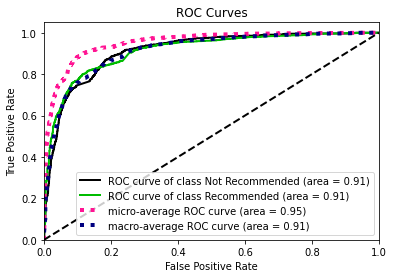

In [43]:
skplt.metrics.plot_roc(y_test, nb.predict_proba(X_test)) 

<div style="text-align:justify">The ROC below shown that curve closer to the top-left corner and it's indicate that the model have a better performance.</div>
<div style="text-align:justify">"Not Recommended" target class and "Recommended" target class have the same ROC values, it was equal to 0.91.  When the ROC value getting closer to 1, this mean that the model reach ideal point.<div>
    
    
    
    

<h2>Conclusion</h2>

From the analysis above we can conclude that :<br>
1. Model have a good performance with accuracy equal to 89% <br>
2. Recall for "Recommended" values as positive target class have value equal to 0.95, this means that "Recommended" review text have 95% predicted correctly.
3. Recall for "Recommended" values as positive target class have value equal to 0.92, this means that "Recommended" review text have 92% predicted positive value which actually positive.
4. Model have RUC curve that closer to 1, this means that model have a good performance in True Positive Rate.
5. Multinomial Naive Bayes is good classification model in sentiment analysis text. This model can accurately predict whether product recommended or not by analyze customers review.